In [114]:
# load the hmm
import pickle
import numpy as np

model_name = "600-word-hmm-700.pkl"
fname = f"/n/holyscratch01/sham_lab/summer_2024/models/{model_name}"

with open(fname, "rb") as f:
    hmm = pickle.load(f)

In [115]:
# Loading the dictionary from the file
tokenizer_filename = "tokenizers/simple-600.pkl"
with open(tokenizer_filename, 'rb') as file:
    tokenizer_dict = pickle.load(file)

In [116]:
sentence1 = "Once upon a time there was a little boy named Ben. Ben loved to explore the world around him."
sentence2 = "One day, a boy named Tim went to the park to play. He"
sentence3 = """Once upon a time, there was a smooth vase. It was very pretty. The vase lived in a small house with a girl named Lily and her mom.
One day, Lily and her mom went outside to play. Before they left, her mom said, "Lily, please close the door." Lily closed the door and they played all day.
When they came back, they saw the smooth vase on the floor. It was broken! Lily"""
sentence4 = """Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through the"""

examples = [
    sentence1,
    sentence2,
    sentence3,
    sentence4,
    """Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking through""",
    """Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was walking""",
    """Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben was""",
    """Once upon a time there was a little boy named Ben. Ben loved to explore the world around him. He saw many amazing things, like beautiful vases that were on display in a store. One day, Ben""",
    """Once upon a time there was a""",
    """Once upon a time there was a little""", # the last two are in train set
    'Once upon a time, there was a brown dog. The dog liked to run and play. One day, the dog went far away from home. He did not know how to go back.\nThe dog saw a big tree. He thought, "Maybe if I go around the tree, I will find my home." He went around the tree, but he did not find his home. The dog was sad.\nThen, the dog saw a little girl. The girl knew the dog. She said, "I know where your home is!" The girl took the dog back to his home. The dog was so happy. He did a big jump and gave the girl a hug. From that day, the\n',
    'Once upon a time, there was a tall tree. A little cat lived in the tree. The cat was happy and liked to play all day.\nOne day, a big man came to the tree. He wanted to cut the tree down. The cat was scared and said, "Please don\'t cut my tree!" The big man stopped and looked at the cat. He did not know the cat could talk.\nThe cat and the big man became friends. They played together and had fun. The big man decided not to cut the tree. The cat\n',
 
]

In [117]:
from typing import List
import re

def explode_into_words(story: str) -> List[str]:
    # explode a story into a list of words and single-char non-alphanumerics (e.g. punctuations)
    return re.findall(r'\<\|endoftext\|\>|\w+|\W', story)

eos_token = "<|endoftext|>"
eos_id = tokenizer_dict[eos_token]

detokenize_dict = dict()
for k, v in tokenizer_dict.items():
    detokenize_dict[v] = k

def tokenize_word(word: str):
    if word not in tokenizer_dict.keys():
        return eos_id
    return tokenizer_dict[word]

def detokenize_sentence(sentence: List[int], highlight:str="") -> str:
    return highlight.join([detokenize_dict[token_id] for token_id in sentence])

def tokenize_sentences(sentences: List[str]) -> List[List[int]]:
    tokenized_sentences = []
    for sentence in sentences:
        tokenized_sentence = [tokenize_word(word.lower()) for word in explode_into_words(sentence)]
        tokenized_sentences.append(tokenized_sentence)
    return tokenized_sentences

In [118]:
tokenized_examples = tokenize_sentences(examples)
tokenized_examples

[[254,
  414,
  539,
  414,
  520,
  414,
  304,
  414,
  561,
  414,
  565,
  414,
  520,
  414,
  156,
  414,
  91,
  414,
  176,
  414,
  77,
  309,
  414,
  77,
  414,
  275,
  414,
  317,
  414,
  33,
  414,
  434,
  414,
  1,
  414,
  212,
  414,
  495,
  309],
 [406,
  414,
  397,
  362,
  414,
  520,
  414,
  91,
  414,
  176,
  414,
  562,
  414,
  235,
  414,
  317,
  414,
  434,
  414,
  408,
  414,
  317,
  414,
  23,
  309,
  414,
  90],
 [254,
  414,
  539,
  414,
  520,
  414,
  304,
  362,
  414,
  561,
  414,
  565,
  414,
  520,
  414,
  248,
  414,
  248,
  309,
  414,
  515,
  414,
  565,
  414,
  199,
  414,
  458,
  309,
  414,
  434,
  414,
  248,
  414,
  354,
  414,
  280,
  414,
  520,
  414,
  98,
  414,
  518,
  414,
  43,
  414,
  520,
  414,
  346,
  414,
  176,
  414,
  2,
  414,
  491,
  414,
  142,
  414,
  123,
  309,
  536,
  406,
  414,
  397,
  362,
  414,
  2,
  414,
  491,
  414,
  142,
  414,
  123,
  414,
  235,
  414,
  218,
  414,
  317,
  414

In [119]:
# get the length of each tokenized example
tokenized_lengths = [len(x) for x in tokenized_examples]
tokenized_lengths

[39, 27, 163, 86, 84, 82, 80, 78, 13, 15, 262, 208]

In [120]:
# wrap tokens with []
seq = [[token] for tokenized_example in tokenized_examples for token in tokenized_example]

In [121]:
# this gets the hidden states for the observed emissions
_, ss = hmm.decode(seq, lengths=tokenized_lengths)
ss

array([256,  60,  60, ..., 265, 694, 409])

In [122]:
# last hidden states
last_hidden_states = []
for tokenized_example, tokenized_length in zip(tokenized_examples, tokenized_lengths):
    last_hidden_states.append(ss[tokenized_length-1])

print(last_hidden_states)

[409, 128, 347, 60, 13, 347, 647, 409, 647, 347, 525, 128]


In [123]:
# transition matrix of hidden states
hmm.transmat_.shape

(700, 700)

In [124]:
def predict(hidden_state: int, state_transitions, emission_matrix, num_emissions, samp=True):
    """
    Predicts a sequence of emissions using a Hidden Markov Model (HMM) given initial conditions.

    Args:
        hidden_state (int): The initial hidden state from which the prediction begins.
        state_transitions (2D array-like): A matrix where each row represents a hidden state's probability
            distribution over possible next states. The matrix is of shape `(num_states, num_states)`.
        emission_matrix (2D array-like): A matrix where each row represents the emission probabilities
            of a hidden state over possible emissions. The matrix is of shape `(num_states, num_emissions)`.
        num_emissions (int): The number of emissions to generate in the sequence.
        samp (bool, optional): If True, transitions and emissions are sampled according to their probability
            distributions. If False, the next state and emission are chosen deterministically using `argmax`.
            Default is True.

    Returns:
        List[int]: A list of emissions generated by the HMM process.
    """
    emissions = []
    for _ in range(num_emissions):
        probabilities = state_transitions[hidden_state]
        if samp:
            next_state = np.random.choice(len(probabilities), p=probabilities)
        else:
            next_state = np.argmax(probabilities)
        e_probs = emission_matrix[next_state]
        if samp:
            emission = np.random.choice(len(e_probs), p=e_probs)
        else:
            emission = np.argmax(e_probs)
        emissions.append(emission)
        hidden_state = next_state
    return emissions

In [125]:
for i ,state in enumerate(last_hidden_states):
    new_ems = predict(state, hmm.transmat_, hmm.emissionprob_, 10)
    print("Input:")
    print(detokenize_sentence(tokenized_examples[i]))
    print("Output:")
    print(detokenize_sentence(new_ems,highlight='^'))
    print("\n---------------\n")

Input:
once upon a time there was a little boy named ben. ben loved to explore the world around him.
Output:
or^owl^also^bobo^also^mom^also^face^waited^also

---------------

Input:
one day, a boy named tim went to the park to play. he
Output:
more^also^red^also^ben^also^face^waited^also^what

---------------

Input:
once upon a time, there was a <|endoftext|> <|endoftext|>. it was very pretty. the <|endoftext|> lived in a small house with a girl named lily and her mom.
one day, lily and her mom went outside to play. before they left, her mom said, "lily, please close the door." lily <|endoftext|> the door and they played all day.
when they came back, they saw the <|endoftext|> <|endoftext|> on the floor. it was broken! lily
Output:
also^head^also^red^also^lion^also^come^also^both

---------------

Input:
once upon a time there was a little boy named ben. ben loved to explore the world around him. he saw many <|endoftext|> things, like beautiful <|endoftext|> that were on <|endoftext|>

In [126]:
for i ,state in enumerate(last_hidden_states):
    new_ems = predict(state, hmm.transmat_, hmm.emissionprob_, 40, samp=True)
    print("Input:")
    print(detokenize_sentence(tokenized_examples[i]))
    print("Output:")
    print(detokenize_sentence(new_ems,highlight='^'))
    print("\n---------------\n")

Input:
once upon a time there was a little boy named ben. ben loved to explore the world around him.
Output:
also^sea^also^surprise^also^told^also^hopped^also^red^also^catch^lived^also^lost^also^very^also^kept^also^train^also^needed^also^red^also^kept^also^books^also^explore^also^tiny^also^through^lived^found^red^also^party

---------------

Input:
one day, a boy named tim went to the park to play. he
Output:
sam^also^red^also^something^also^if^lived^another^or^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another^another

---------------

Input:
once upon a time, there was a <|endoftext|> <|endoftext|>. it was very pretty. the <|endoftext|> lived in a small house with a girl named lily and her mom.
one day, lily and her mom went outside to play. before they left, her mom said, "lily, please close the door." li

In [127]:
# let's check the also-space bug
hmm.transmat_

array([[0.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 3.79799188e-029, 1.61455823e-163],
       [2.57021605e-100, 0.00000000e+000, 7.56796558e-216, ...,
        0.00000000e+000, 3.45571332e-081, 1.32137312e-187],
       [3.12631373e-208, 0.00000000e+000, 0.00000000e+000, ...,
        0.00000000e+000, 7.43894643e-187, 4.76037675e-178],
       ...,
       [6.30963885e-159, 1.39811995e-055, 0.00000000e+000, ...,
        7.51398236e-285, 5.48861122e-203, 0.00000000e+000],
       [6.67033321e-232, 1.30337656e-041, 1.71811472e-042, ...,
        3.49679902e-319, 2.77433539e-167, 2.84406201e-226],
       [1.04261421e-195, 0.00000000e+000, 9.56957045e-102, ...,
        4.60907442e-112, 5.25558992e-315, 0.00000000e+000]])

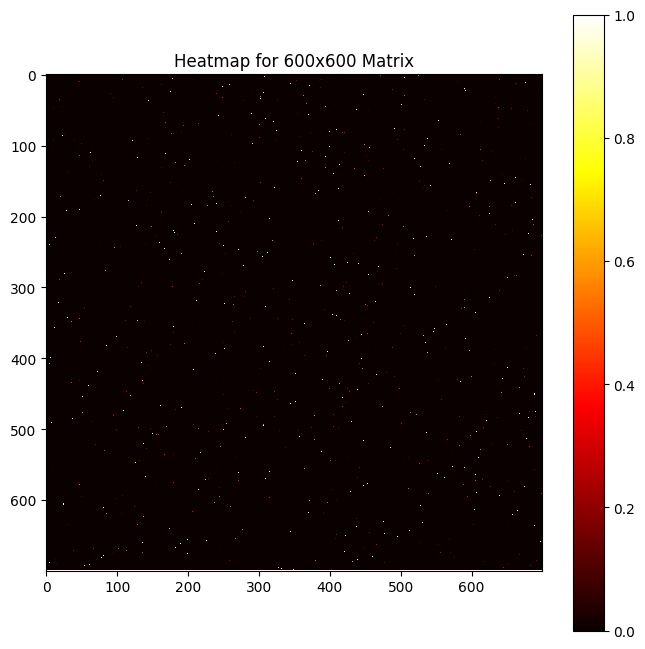

In [128]:
import matplotlib.pyplot as plt

# Step 2: Plot the heatmap
plt.figure(figsize=(8, 8))  # Set figure size to make the heatmap readable
plt.imshow(hmm.transmat_, cmap='hot', interpolation='nearest')  # 'hot' colormap for heatmap
plt.colorbar()  # Add a colorbar to the side
plt.title('Heatmap for 600x600 Matrix')
plt.show()

In [129]:
# see which column is most popular
# Step 1: Calculate the mean of the entire matrix

matrix_mean = np.mean(hmm.transmat_)

# Step 2: Count the number of values above the mean for each column
above_mean_counts = np.sum(hmm.transmat_ > 0.0000001*matrix_mean, axis=0)

# Step 3: Find the index of the column with the most values above the mean
column_with_max_above_mean = np.argmax(above_mean_counts)

# Step 4: Output the result
print(f"The column with the most values above the mean is: {column_with_max_above_mean}")
print(f"The number of values above the mean in this column is: {above_mean_counts[column_with_max_above_mean]}")

The column with the most values above the mean is: 274
The number of values above the mean in this column is: 23


In [130]:
# these columns have the most other rows pointing to them (11)
mx = max(above_mean_counts)
[i for i,x in enumerate(above_mean_counts) if x == mx], mx

([274, 409], 23)

In [131]:
# find the hidden states with high probability of emitting spaces
# find the hidden states with high probability of emitting also
# check whether we are hitting any of these
space_id = tokenizer_dict[' ']
also_id = tokenizer_dict['also']

In [132]:
space_emission_probs = [features[space_id] for features in hmm.emissionprob_]
also_emission_probs = [features[also_id] for features in hmm.emissionprob_]

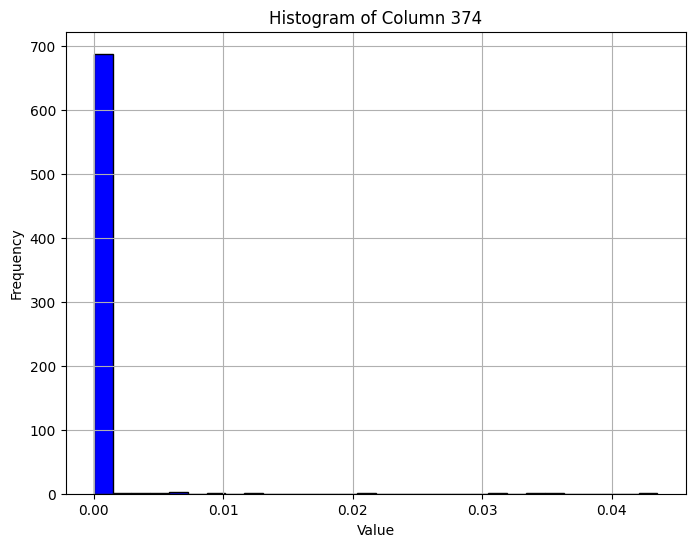

In [133]:
plt.figure(figsize=(8, 6))  # Set figure size
plt.hist(space_emission_probs, bins=30, color='blue', edgecolor='black')  # Plot histogram with 30 bins
plt.title('Histogram of Column 374')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid to the plot
plt.show()

In [134]:
# get the quartiles
np.percentile(space_emission_probs, [25, 50, 75])

array([2.98016966e-90, 1.65739297e-58, 7.96190338e-38])

In [135]:
space_ranks = [ (v,i) for i,v in enumerate(space_emission_probs)]
sorted(space_ranks, reverse=True)[:20]

[(0.043532873503097584, 11),
 (0.036182357196022766, 146),
 (0.03474042534837443, 181),
 (0.030793155949119085, 612),
 (0.02056313266179261, 535),
 (0.011766336945244395, 499),
 (0.009241425552979363, 78),
 (0.00684530714190623, 438),
 (0.006490138259375215, 265),
 (0.005802285437591929, 244),
 (0.003149110975405223, 667),
 (0.0017958932048796488, 108),
 (0.0013627680953891197, 128),
 (0.0012690155228945608, 439),
 (0.0008394195013651034, 155),
 (0.0008349038600215985, 81),
 (0.0005201962098617878, 60),
 (0.00022708441188245364, 66),
 (0.00010879945776433459, 694),
 (9.76391744868402e-05, 256)]

In [136]:
also_ranks = [ (v,i) for i,v in enumerate(also_emission_probs)]
sorted(also_ranks, reverse=True)[:20]

[(1.0, 698),
 (1.0, 688),
 (1.0, 679),
 (1.0, 669),
 (1.0, 666),
 (1.0, 659),
 (1.0, 652),
 (1.0, 644),
 (1.0, 639),
 (1.0, 634),
 (1.0, 633),
 (1.0, 632),
 (1.0, 619),
 (1.0, 611),
 (1.0, 609),
 (1.0, 604),
 (1.0, 603),
 (1.0, 596),
 (1.0, 583),
 (1.0, 581)]

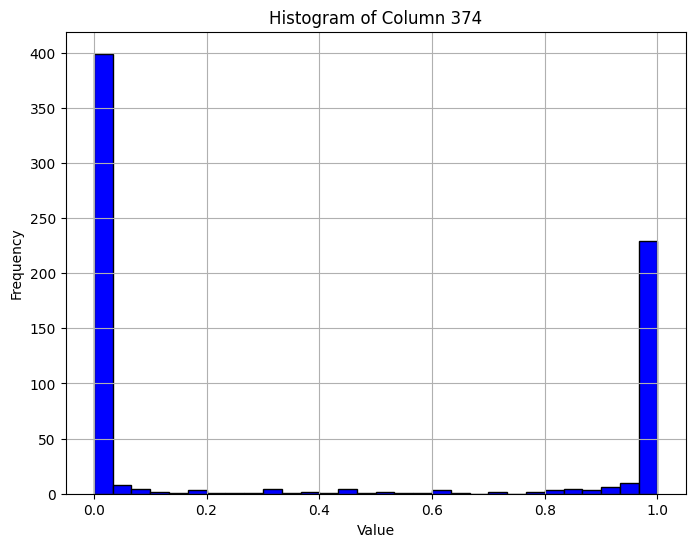

In [137]:
plt.figure(figsize=(8, 6))  # Set figure size
plt.hist(also_emission_probs, bins=30, color='blue', edgecolor='black')  # Plot histogram with 30 bins
plt.title('Histogram of Column 374')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)  # Add grid to the plot
plt.show()

In [138]:
space_id

414

In [139]:
also_id

545

In [140]:
# num hidden states who emit
cnts = [0]*hmm.n_features

for row_id in range(hmm.transmat_.shape[0]):
    for emit_id in range(hmm.n_features):
        cnts[emit_id] += hmm.emissionprob_[row_id][emit_id] > 0.5

In [141]:
token_vs_freq = [(cnt,detokenize_dict[i]) for i,cnt in enumerate(cnts)]

In [142]:
sorted(token_vs_freq,reverse=True)

[(267, 'also'),
 (32, 'waited'),
 (29, 'lived'),
 (18, 'seen'),
 (11, 'more'),
 (9, 'red'),
 (9, 'or'),
 (7, 'mom'),
 (5, 'kept'),
 (5, 'even'),
 (4, 'stick'),
 (3, 'gave'),
 (2, 'well'),
 (2, 'water'),
 (2, 'watched'),
 (2, 'sorry'),
 (2, 'rock'),
 (2, 'park'),
 (2, 'close'),
 (2, 'another'),
 (1, 'world'),
 (1, 'what'),
 (1, 'way'),
 (1, 'watch'),
 (1, 'try'),
 (1, 'tried'),
 (1, 'top'),
 (1, 'tiny'),
 (1, 't'),
 (1, 'store'),
 (1, 'some'),
 (1, 'scary'),
 (1, 'people'),
 (1, 'owl'),
 (1, 'out'),
 (1, 'maybe'),
 (1, 'its'),
 (1, 'inside'),
 (1, 'if'),
 (1, 'home'),
 (1, 'helped'),
 (1, 'held'),
 (1, 'game'),
 (1, 'fish'),
 (1, 'favorite'),
 (1, 'face'),
 (1, 'every'),
 (1, 'don'),
 (1, 'catch'),
 (1, 'bob'),
 (1, 'birds'),
 (1, 'at'),
 (1, 'about'),
 (0, 'yummy'),
 (0, 'your'),
 (0, 'you'),
 (0, 'yes'),
 (0, 'yellow'),
 (0, 'yard'),
 (0, 'wrong'),
 (0, 'wow'),
 (0, 'would'),
 (0, 'worry'),
 (0, 'worked'),
 (0, 'work'),
 (0, 'woods'),
 (0, 'won'),
 (0, 'with'),
 (0, 'wished'),
 (0, 'w

In [143]:
sorted(token_vs_freq)

[(0, '\n'),
 (0, ' '),
 (0, '!'),
 (0, '"'),
 (0, "'"),
 (0, ','),
 (0, '-'),
 (0, '.'),
 (0, ':'),
 (0, '<|endoftext|>'),
 (0, '?'),
 (0, 'a'),
 (0, 'adventure'),
 (0, 'after'),
 (0, 'again'),
 (0, 'agreed'),
 (0, 'air'),
 (0, 'all'),
 (0, 'alone'),
 (0, 'always'),
 (0, 'am'),
 (0, 'amy'),
 (0, 'an'),
 (0, 'and'),
 (0, 'angry'),
 (0, 'animals'),
 (0, 'anymore'),
 (0, 'anything'),
 (0, 'apple'),
 (0, 'are'),
 (0, 'around'),
 (0, 'as'),
 (0, 'ask'),
 (0, 'asked'),
 (0, 'ate'),
 (0, 'away'),
 (0, 'baby'),
 (0, 'back'),
 (0, 'bad'),
 (0, 'bag'),
 (0, 'ball'),
 (0, 'be'),
 (0, 'bear'),
 (0, 'beautiful'),
 (0, 'became'),
 (0, 'because'),
 (0, 'bed'),
 (0, 'before'),
 (0, 'began'),
 (0, 'behind'),
 (0, 'being'),
 (0, 'ben'),
 (0, 'best'),
 (0, 'better'),
 (0, 'big'),
 (0, 'bigger'),
 (0, 'bird'),
 (0, 'bit'),
 (0, 'blew'),
 (0, 'blue'),
 (0, 'boat'),
 (0, 'bobo'),
 (0, 'book'),
 (0, 'books'),
 (0, 'both'),
 (0, 'box'),
 (0, 'boy'),
 (0, 'brave'),
 (0, 'bright'),
 (0, 'broke'),
 (0, 'broken')

In [144]:
cnts = [0]*hmm.n_features

for row_id in range(hmm.transmat_.shape[0]):
    for emit_id in range(hmm.n_features):
        cnts[emit_id] += hmm.emissionprob_[row_id][emit_id] > 0.05
token_vs_freq = [(cnt,detokenize_dict[i]) for i,cnt in enumerate(cnts)]
sorted(token_vs_freq)

[(0, '\n'),
 (0, ' '),
 (0, '"'),
 (0, '-'),
 (0, '<|endoftext|>'),
 (0, '?'),
 (0, 'adventure'),
 (0, 'again'),
 (0, 'agreed'),
 (0, 'air'),
 (0, 'all'),
 (0, 'amy'),
 (0, 'an'),
 (0, 'anymore'),
 (0, 'around'),
 (0, 'as'),
 (0, 'ate'),
 (0, 'away'),
 (0, 'baby'),
 (0, 'back'),
 (0, 'bad'),
 (0, 'ball'),
 (0, 'be'),
 (0, 'bear'),
 (0, 'became'),
 (0, 'bed'),
 (0, 'behind'),
 (0, 'big'),
 (0, 'bigger'),
 (0, 'blew'),
 (0, 'book'),
 (0, 'box'),
 (0, 'boy'),
 (0, 'bright'),
 (0, 'broken'),
 (0, 'brown'),
 (0, 'bunny'),
 (0, 'but'),
 (0, 'butterfly'),
 (0, 'buy'),
 (0, 'by'),
 (0, 'called'),
 (0, 'can'),
 (0, 'car'),
 (0, 'chair'),
 (0, 'clapped'),
 (0, 'clean'),
 (0, 'clothes'),
 (0, 'cold'),
 (0, 'colorful'),
 (0, 'colors'),
 (0, 'come'),
 (0, 'cool'),
 (0, 'couldn'),
 (0, 'cream'),
 (0, 'curious'),
 (0, 'dance'),
 (0, 'day'),
 (0, 'decided'),
 (0, 'dirty'),
 (0, 'do'),
 (0, 'doll'),
 (0, 'done'),
 (0, 'dress'),
 (0, 'duck'),
 (0, 'each'),
 (0, 'end'),
 (0, 'enjoyed'),
 (0, 'ever'),
 (0

In [145]:
# conclusion: the hmm already has this baked within
# so if anything, it is the hmm training